<a href="https://colab.research.google.com/github/fl4izdn4g/colab-training/blob/main/gdzie-te-kotki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jak rozpoznać kotki

W tym notatniku wytrenujemy sieć neuronową, aby rozpoznawała nam koty. Notatnik na podstawie Lab6-Cats-v-Dogs (https://colab.research.google.com/github/lmoroney/mlday-tokyo/blob/master/Lab6-Cats-v-Dogs.ipynb) 

Najpierw rozpoczniemy od zaimportowania najważniejszych bibliotek.

In [12]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

## Pozyskiwanie danych
Następnie pobieramy bazę obrazków do naszego eksperymentu.

In [13]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2021-01-22 07:45:58--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.35.72.22, 2600:1407:21:28d::e59, 2600:1407:21:2a0::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.35.72.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   208MB/s    in 3.9s    

2021-01-22 07:46:02 (202 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [14]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Oczekiwana liczba obrazków dla każdej z klas:
# 12501
# 12501

12501
12501


Tworzym miejsce na przetworzone dane.

In [15]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

Tworzymy metodę do podziału danych na dane treningowe i testowe. Ustawiamy na podział na 0.9 czyli 90% trafi do zbioru treningowego, a 10% do testowego.

In [16]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Powinno pojawić się coś takiego
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Sprawdzamy czy wszystkie pliki są na swoich miejscach.

In [17]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Powinno zwrócić to:
# 11250
# 11250
# 1250
# 1250

12363
12379
2363
2379


Budujemy model wykorzystując widok sekwencyjny.

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])


Przetwarzamy obrazki, aby się zgadzały z naszą siecią. Sieć oczekuje obrazków 150x150 w RGB.

In [19]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Powinno być to:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 24740 images belonging to 2 classes.
Found 4742 images belonging to 2 classes.


No i zaczynamy trenowanie modelu... Będzie długo...

In [27]:
# ok. 17 minut na wytrenowanie
history = model.fit(train_generator, epochs=5, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6)

Epoch 1/5
17/90 [====>.........................] - ETA: 51s - loss: 0.6029 - acc: 0.6750

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 69s 762ms/step - loss: 0.5809 - acc: 0.6994 - val_loss: 0.4932 - val_acc: 0.7693
Epoch 2/5
90/90 [==============================] - 67s 748ms/step - loss: 0.5165 - acc: 0.7441 - val_loss: 0.5278 - val_acc: 0.7200
Epoch 3/5
90/90 [==============================] - 67s 743ms/step - loss: 0.4777 - acc: 0.7700 - val_loss: 0.5060 - val_acc: 0.7347
Epoch 4/5
90/90 [==============================] - 67s 745ms/step - loss: 0.4403 - acc: 0.7918 - val_loss: 0.3599 - val_acc: 0.8387
Epoch 5/5
90/90 [==============================] - 67s 747ms/step - loss: 0.4070 - acc: 0.8125 - val_loss: 0.3818 - val_acc: 0.8193


Na koniec walidacja czy wszystko poszło OK. Ważne czy zmniejsza się funkcja straty.

<Figure size 432x288 with 0 Axes>

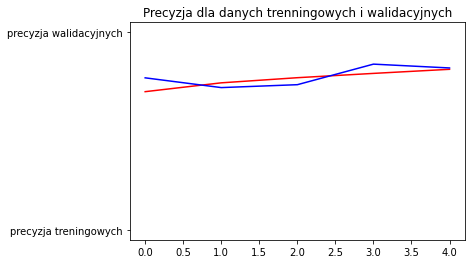

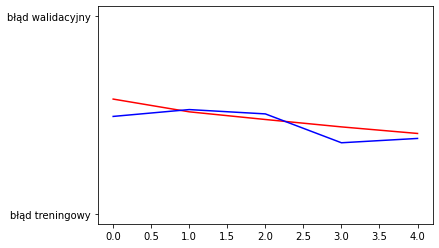

<Figure size 432x288 with 0 Axes>

In [28]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# pobranie wartości dla accuracy i loss
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # ile epok

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "precyzja treningowych")
plt.plot(epochs, val_acc, 'b', "precyzja walidacyjnych")
plt.title('Precyzja dla danych trenningowych i walidacyjnych')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "błąd treningowy")
plt.plot(epochs, val_loss, 'b', "błąd walidacyjny")
plt.figure()


Na koniec mechanizm predykcyjny. Wgrywamy obrazek i patrzymy jak świat płonie :D
Mogą być nieoczekiwane wyniki ;)

Saving kotek_1.jpeg to kotek_1 (2).jpeg
[0.]
Znalazłem KOTA


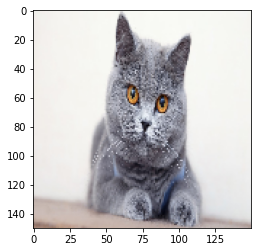

In [35]:
# sprawdzamy co się nauczyło
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  plt.imshow(img)
  if classes[0]>0.5:
    print("Znalazłem PSA")
  else:
    print("Znalazłem KOTA")